In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import ta  # Technical Analysis library for additional indicators


In [6]:
# Download the stock data (Apple Inc. as an example)
stock_data = yf.download('AAPL', start='2010-01-01', end='2021-12-31')

# Display the first few rows of the stock data
stock_data.head()


C:\Users\Muhammad Bin Mehmood\AppData\Local\Temp\ipykernel_9028\3269103827.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('AAPL', start='2010-01-01', end='2021-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479382,6.409054,6.449628,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328811,6.371488,6.282828,6.363974,477131200
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800


In [11]:
# Add Technical Indicators (e.g., Moving Averages, RSI, Bollinger Bands)
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

# RSI: Extract Close column as a 1-dimensional series
stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close'].squeeze()).rsi()

# Bollinger Bands: Compute Upper and Lower Bands
bb = ta.volatility.BollingerBands(stock_data['Close'].squeeze())
stock_data['Upper Band'] = bb.bollinger_hband()
stock_data['Lower Band'] = bb.bollinger_lband()

# Volume Moving Average: 50-day Moving Average of Volume
stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=50).mean()

# Fill any missing values created by the indicators
stock_data.fillna(method='bfill', inplace=True)

# Display the first few rows with technical indicators
stock_data.head()


C:\Users\Muhammad Bin Mehmood\AppData\Local\Temp\ipykernel_9028\3656286748.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)


Price,Close,High,Low,Open,Volume,SMA_50,SMA_200,RSI,Upper Band,Lower Band,Volume_MA
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600,NaN,NaN,29.355556,6.606134,5.840266,648164608.0
2010-01-05,6.443016,6.479382,6.409054,6.449628,601904800,NaN,NaN,29.355556,6.606134,5.840266,648164608.0
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000,NaN,NaN,29.355556,6.606134,5.840266,648164608.0
2010-01-07,6.328811,6.371488,6.282828,6.363974,477131200,NaN,NaN,29.355556,6.606134,5.840266,648164608.0
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800,NaN,NaN,29.355556,6.606134,5.840266,648164608.0


In [12]:
# Use more features, such as Open, High, Low, Close, and Volume
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'Upper Band', 'Lower Band', 'Volume_MA']
data = stock_data[features]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Display the first few rows of the normalized data
scaled_data[:5]


c:\Users\Muhammad Bin Mehmood\Documents\ME-WORK\GitHub\INT-1\.venv\lib\site-packages\sklearn\utils\_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\Muhammad Bin Mehmood\Documents\ME-WORK\GitHub\INT-1\.venv\lib\site-packages\sklearn\utils\_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


array([[0.0036801 , 0.00321626, 0.00392361, 0.00385451, 0.24604896,
               nan,        nan, 0.11950685, 0.00251403, 0.00135812,
        0.76370276],
       [0.00388455, 0.00340575, 0.00407785, 0.00391946, 0.3048399 ,
               nan,        nan, 0.11950685, 0.00251403, 0.00135812,
        0.76370276],
       [0.0038461 , 0.00334317, 0.00363461, 0.00332092, 0.27780465,
               nan,        nan, 0.11950685, 0.00251403, 0.00135812,
        0.76370276],
       [0.00338653, 0.00278163, 0.00333321, 0.00325247, 0.23702808,
               nan,        nan, 0.11950685, 0.00251403, 0.00135812,
        0.76370276],
       [0.00313315, 0.00278163, 0.00333498, 0.0034982 , 0.22098437,
               nan,        nan, 0.11950685, 0.00251403, 0.00135812,
        0.76370276]])

In [13]:
# Create Dataset for Training the Model
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])  # Features (previous 60 days for multiple features)
        y.append(data[i, 3])  # Close price as the target
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

# Reshape X for the LSTM model
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Display the shape of the dataset
X.shape, y.shape


((2960, 60, 11), (2960,))

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the split datasets
X_train.shape, X_test.shape


((2368, 60, 11), (592, 60, 11))

In [15]:
# Build the LSTM model with Dropout to prevent overfitting
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # First LSTM Layer
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=100, return_sequences=False))  # Second LSTM Layer
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(units=1))  # Output Layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()


c:\Users\Muhammad Bin Mehmood\Documents\ME-WORK\GitHub\INT-1\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        44,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,301 (489.46 KB)

 Trainable params: 125,301 (489.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: nan - val_loss: nan
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: nan - val_loss: nan
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: nan - val_loss: nan
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: nan - val_loss: nan
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: nan - val_loss: nan
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: nan - val_loss: nan
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: nan - val_loss: nan
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: nan - val_loss: nan
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: nan - val_loss: nan
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: nan - val_loss: nan
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: nan - val_loss: nan
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: nan - val_loss: nan
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 76m

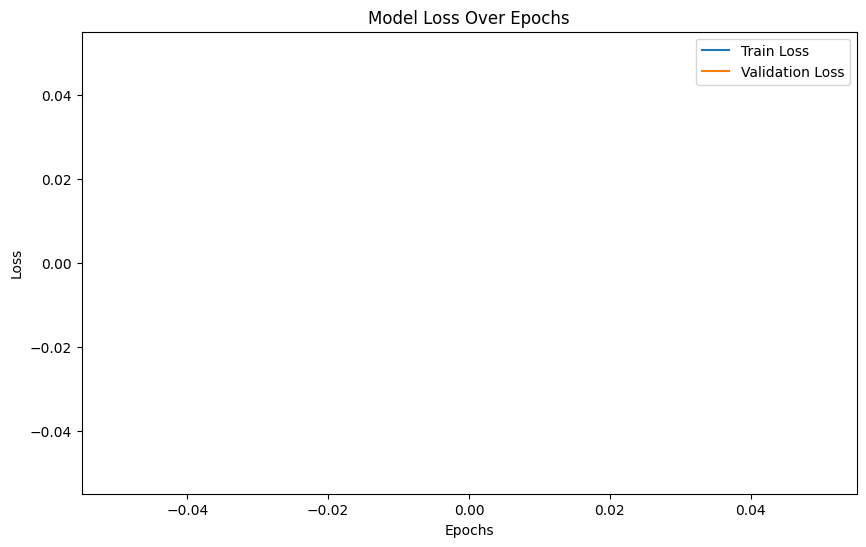

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


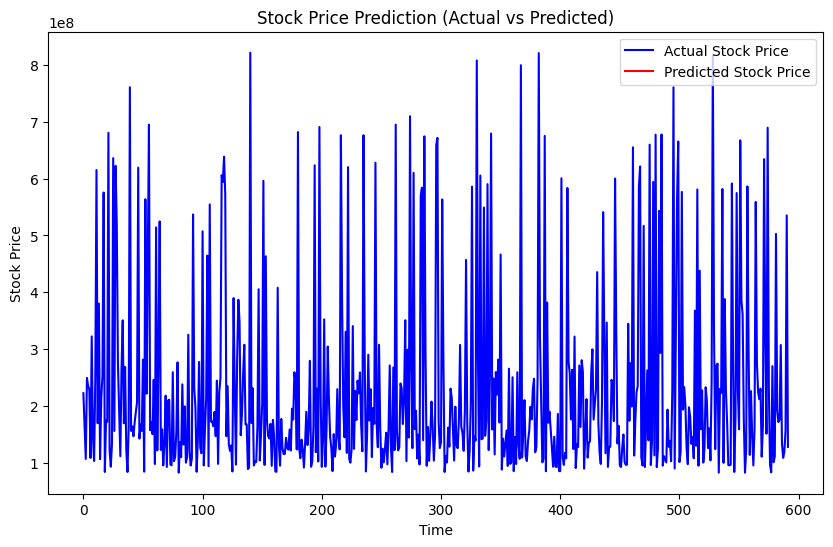

In [17]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values back to the original scale
predictions = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], X_test.shape[2]-1)), predictions)))[:, -1]
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_test.shape[2]-1)), y_test.reshape(-1, 1))))[:, -1]

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Actual vs Predicted)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [18]:
# Save the predictions to a CSV file (Optional)
predictions_df = pd.DataFrame(predictions, columns=['Predicted Price'])
predictions_df.to_csv('predicted_stock_prices.csv', index=False)

# Print message indicating that predictions are saved
print("Predictions for the test set saved to 'predicted_stock_prices.csv'.")


Predictions for the test set saved to 'predicted_stock_prices.csv'.
